In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Date Preparation #

In [2]:
df = pd.read_csv("course_lead_scoring.csv")
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [3]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [4]:
numerical_vars = df.select_dtypes(include=['int64', 'float64'])
categorical_vars = df.select_dtypes(include=['object'])
 
print("Numerical Variables:")
print(numerical_vars.columns)
 
print("\nCategorical Variables:")
print(categorical_vars.columns)

Numerical Variables:
Index(['number_of_courses_viewed', 'annual_income', 'interaction_count',
       'lead_score', 'converted'],
      dtype='object')

Categorical Variables:
Index(['lead_source', 'industry', 'employment_status', 'location'], dtype='object')


In [5]:
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count','lead_score']

categorical = ['lead_source', 'industry', 'employment_status', 'location']

# Replace missing values in categorical features with 'NA'
df[categorical] = df[categorical].fillna('NA')

# Replace missing values in numerical features with 0.0
df[numerical] = df[numerical].fillna(0.0)

In [6]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [7]:
from sklearn.model_selection import train_test_split

In [12]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
len(df_full_train), len(df_test)

(1169, 293)

In [13]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [14]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [15]:
y_full_train = df_full_train.converted.values
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

In [16]:
#del df_full_train['converted']
del df_train['converted']
del df_val['converted']
del df_test['converted']

## Question 1: ROC AUC feature importance ##

In [17]:
from sklearn.metrics import roc_auc_score

In [19]:
# compute AUC on training set using each numerical feature as the prediction score
aucs = {}
for var in numerical:
    preds = df_train[var].values
 
    auc = roc_auc_score(y_train, preds)
       
    aucs[var] = auc

# display results sorted by AUC descending
auc_df = pd.DataFrame.from_dict(aucs, orient='index', columns=['roc_auc']).sort_values('roc_auc', ascending=False)
print(auc_df)

                           roc_auc
number_of_courses_viewed  0.763568
interaction_count         0.738270
lead_score                0.614499
annual_income             0.551958


## Question 2: Training the model ##

In [24]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning

In [21]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
 
dv.fit(train_dicts)
X_train = dv.transform(train_dicts)

In [34]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000, solver='liblinear')

In [35]:
y_pred = model.predict_proba(X_val)[:,1]

convert_decision = (y_pred >= 0.5)
(convert_decision == y_val).mean()

0.6996587030716723

In [36]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val, convert_decision)
accuracy

0.6996587030716723

In [37]:
roc_auc_score(y_val, y_pred).round(3)

0.817

Scaling Numerical features

In [ ]:
from sklearn.preprocessing import StandardScaler

# fit scaler on training numerical features and transform train/val (and optionally full_train/test)
scaler = StandardScaler()
scaler.fit(df_train[numerical].values)

df_train[numerical] = scaler.transform(df_train[numerical].values)
df_val[numerical]   = scaler.transform(df_val[numerical].values)
df_full_train[numerical] = scaler.transform(df_full_train[numerical].values)
df_test[numerical] = scaler.transform(df_test[numerical].values)

# rebuild dicts and feature matrix with scaled numerical features
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
val_dicts = df_val[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dicts)
X_train = dv.transform(train_dicts)
X_val = dv.transform(val_dicts)

#print("Train numerical means (after scaling):", df_train[numerical].mean().round(6).to_dict())
#print("Train numerical stds  (after scaling):", df_train[numerical].std().round(6).to_dict())

In [39]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000, solver='liblinear')

In [40]:
y_pred = model.predict_proba(X_val)[:,1]

In [41]:
roc_auc_score(y_val, y_pred).round(3)

0.921

# Question 3: Precision and Recall #

Intersection threshold(s) (approx): [0.5333]
Threshold with minimal |precision - recall|: 0.53 (precision=0.8779, recall=0.8830)


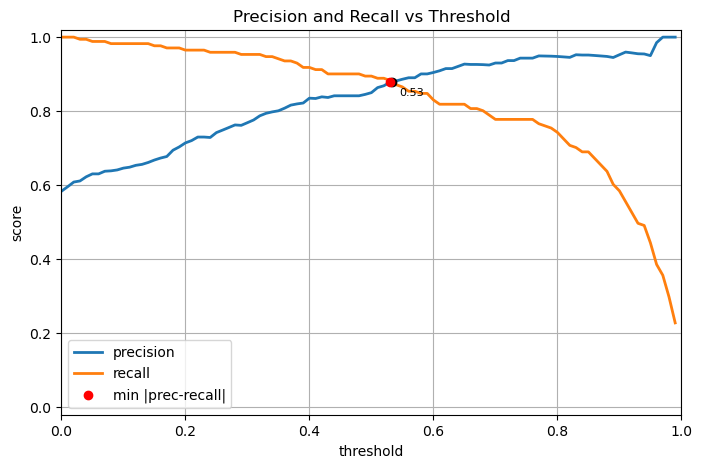

In [42]:
# compute precision and recall for thresholds 0.00..1.00
thresholds = np.arange(0.0, 1.0, 0.01)

precisions = []
recalls = []
for t in thresholds:
    preds = (y_pred >= t).astype(int)
    tp = int(((preds == 1) & (y_val == 1)).sum())
    fp = int(((preds == 1) & (y_val == 0)).sum())
    fn = int(((preds == 0) & (y_val == 1)).sum())
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    precisions.append(prec)
    recalls.append(rec)

precisions = np.array(precisions)
recalls = np.array(recalls)

# find approximate intersection points (linear interpolation where sign changes)
diff = precisions - recalls
signs = np.sign(diff)
intersections = []

# exact matches
exact_idx = np.where(np.isclose(diff, 0.0, atol=1e-12))[0]
for i in exact_idx:
    intersections.append(float(thresholds[i]))

# sign-change segments -> linear interpolation for a better estimate
for i in range(len(thresholds) - 1):
    if signs[i] == 0:
        continue
    if signs[i] * signs[i + 1] < 0:
        t0, t1 = thresholds[i], thresholds[i + 1]
        p0, p1 = precisions[i], precisions[i + 1]
        r0, r1 = recalls[i], recalls[i + 1]
        # solve p0 + alpha*(p1-p0) = r0 + alpha*(r1-r0)
        denom = (p1 - p0) - (r1 - r0)
        if denom != 0:
            alpha = (r0 - p0) / denom
            t_inter = t0 + alpha * (t1 - t0)
        else:
            t_inter = 0.5 * (t0 + t1)
        intersections.append(float(t_inter))

# threshold with minimal abs difference
idx_min = int(np.argmin(np.abs(diff)))
threshold_min = float(thresholds[idx_min])

# print results
print("Intersection threshold(s) (approx):", sorted(set(np.round(intersections, 4).tolist())))
print(f"Threshold with minimal |precision - recall|: {threshold_min:.2f} "
      f"(precision={precisions[idx_min]:.4f}, recall={recalls[idx_min]:.4f})")

# plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, label='precision', lw=2)
plt.plot(thresholds, recalls, label='recall', lw=2)
plt.xlabel('threshold')
plt.ylabel('score')
plt.title('Precision and Recall vs Threshold')
plt.grid(True)
plt.ylim(-0.02, 1.02)
plt.xlim(0, 1)

# mark intersection points and minimal-diff point
for t in intersections:
    # get interpolated y-value for marking (use precision interpolation)
    p_val = np.interp(t, thresholds, precisions)
    plt.scatter([t], [p_val], color='black', zorder=5)
    plt.annotate(f"{t:.2f}", (t, p_val), textcoords="offset points", xytext=(5, -10), fontsize=8)

plt.scatter([threshold_min], [precisions[idx_min]], color='red', zorder=6, label='min |prec-recall|')
plt.legend()
plt.show()

# Question 4: F1 score #

In [69]:
def f1_score(precision, recall):
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

In [70]:
thresholds = np.arange(0.0, 1.0, 0.01)
f1s = []
for t in thresholds:
    preds = (y_pred >= t).astype(int)
    tp = int(((preds == 1) & (y_val == 1)).sum())
    fp = int(((preds == 1) & (y_val == 0)).sum())
    fn = int(((preds == 0) & (y_val == 1)).sum())
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1s.append(f1_score(prec, rec))

f1s = np.array(f1s)
max_f1 = f1s.max()
best_idxs = np.where(np.isclose(f1s, max_f1))[0]
best_thresholds = thresholds[best_idxs]

print(f"Max F1 = {max_f1:.4f} at threshold(s): {best_thresholds.tolist()}")
print(f"Best threshold (smallest) = {best_thresholds[0]:.2f}")

Max F1 = 0.8889 at threshold(s): [0.39]
Best threshold (smallest) = 0.39


# Question 5: 5-Fold CV # 

In [49]:
from sklearn.model_selection import KFold
import warnings
from sklearn.exceptions import ConvergenceWarning

In [66]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
 
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
 
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
 
    return dv, model

In [52]:
def predict(df, dv, model):
     dicts = df[categorical + numerical].to_dict(orient='records')
 
     X = dv.fit_transform(dicts)
     y_pred = model.predict_proba(X)[:,1]
 
     return y_pred

In [53]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1) 
 
kfold.split(df_full_train)

<generator object _BaseKFold.split at 0x16e2f2ce0>

In [55]:
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

warnings.filterwarnings("ignore", category=ConvergenceWarning)

0.921 +- 0.010


In [71]:
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train_fold = df_full_train.iloc[train_idx]
    df_val_fold = df_full_train.iloc[val_idx]

    y_train_fold = df_train_fold.converted.values
    y_val_fold = df_val_fold.converted.values

    train_dicts = df_train_fold[categorical + numerical].to_dict(orient='records')
    val_dicts = df_val_fold[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train_fold)

    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val_fold, y_pred)
    scores.append(auc)

scores = np.array(scores)
print("AUCs per fold:", np.round(scores, 3).tolist())
print("Mean AUC: %.3f" % scores.mean())
print("Std of AUCs: %.3f" % scores.std())

AUCs per fold: [0.921, 0.932, 0.907, 0.911, 0.932]
Mean AUC: 0.921
Std of AUCs: 0.010


# Question 6: Hyperparameter Tuning #

In [68]:
n_splits = 5
 
for C in [0.000001, 0.001, 1]:   
    scores = []
 
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)  
 
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
 
        y_train = df_train.converted.values
        y_val = df_val.converted.values
 
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
 
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
 
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))
    
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

C=1e-06 0.921 +- 0.010
C=0.001 0.921 +- 0.010
C=1 0.921 +- 0.010
